In [788]:
import numpy as np
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import matplotlib
import os
matplotlib.rcParams['font.size'] = 12
plt.rcParams.update({'figure.figsize':[18,6]})
from matplotlib import cm
import sys
import pyhsmm
from pyhsmm.util.general import rle
import pyhsmm.basic.distributions as distributions
from scipy.stats import entropy

sys.path.append('/home/kirilman/Projects/nir/main nir')
from sequence_generator import SemiMarkovSignal

from pyhsmm.util.text import progprint_xrange


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [789]:
#fit model
def create_model(data, Nmax = 5):
    obs_dim = 1
    dur_distns = []
    Nmax = 5
#     L = 5
#     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
#                     'K':L,
#                      'alphav_0':np.zeros(L)+0.1, 
#                      'alpha_mf':np.zeros(L)+0.1,
#                     }

    obs_hypparams = {'mu_0':np.zeros(obs_dim),
                    'sigma_0':np.eye(obs_dim),
                    'kappa_0':2,
                    'nu_0':obs_dim+5}
    obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]

    
    dur_hypparams = {'alpha_0':45,
                     'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':20,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':30,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':55,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    
    
    dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

    posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
            alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
            init_state_concentration=6., # pretty inconsequential
            obs_distns=obs_distns,
            dur_distns=dur_distns)

#     posteriormodel = pyhsmm.models.HSMM(
#             alpha=6., # На что влияет 
# #             gamma=2., # better to sample over these; see concentration-resampling.py
#             init_state_concentration=6., # pretty inconsequential
#             obs_distns=obs_distns,
#             dur_distns=dur_distns)
    
    posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
    
    fig = plt.figure(figsize=(12,10),dpi = 140)
    for idx in progprint_xrange(150):
        posteriormodel.resample_model(1)
    plt.show()
    return posteriormodel

from multiprocessing import Pool
class hsmm_classifier():
    def __init__(self, N = 5):
        self.models = []
        self.number_model = N
        
    def fit(self,data):
        pool = Pool(4)
        params = [ (data, i + 10) for i in range(self.number_model)]
        self.models = pool.starmap(self.create_model, params)
        pool.close()
        pool.join()
    def log_likelihood(self, data):
#         pool = Pool(self.number_model)
#         return pool(self.models.log_likelihood, [(data,)*self.number_model])
        return np.array([m.log_likelihood(data) for m in self.models])
    
    def test(self):
        for m in self.models:
            print(m.generate(10,1))
            
    def create_model(self,data,seed):
        np.random.seed(seed)
        obs_dim = 1
        dur_distns = []
        Nmax = 7
    #     L = 5
    #     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
    #                     'K':L,
    #                      'alphav_0':np.zeros(L)+0.1, 
    #                      'alpha_mf':np.zeros(L)+0.1,
    #                     }

        obs_hypparams = {'mu_0':np.zeros(obs_dim),
                        'sigma_0':np.eye(obs_dim),
                        'kappa_0':2,
                        'nu_0':obs_dim+5}
        obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]


        dur_hypparams = {'alpha_0':45,
                         'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':20,
    #                      'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':30,
    #                      'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':55,
    #                      'beta_0':1}
#         dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

#         dur_distns = [distributions.GeometricDuration(**dur_hypparams) for state in range(Nmax)]

        dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

        posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
                alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
                init_state_concentration=6., # pretty inconsequential
                obs_distns=obs_distns,
                dur_distns=dur_distns)

    #     posteriormodel = pyhsmm.models.HSMM(
    #             alpha=6., # На что влияет 
    # #             gamma=2., # better to sample over these; see concentration-resampling.py
    #             init_state_concentration=6., # pretty inconsequential
    #             obs_distns=obs_distns,
    #             dur_distns=dur_distns)

        posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
        for idx in progprint_xrange(150):
            posteriormodel.resample_model(1)
        return posteriormodel
    def get_models(self):
        return self.models

In [790]:
np.sqrt(0.09)

0.3

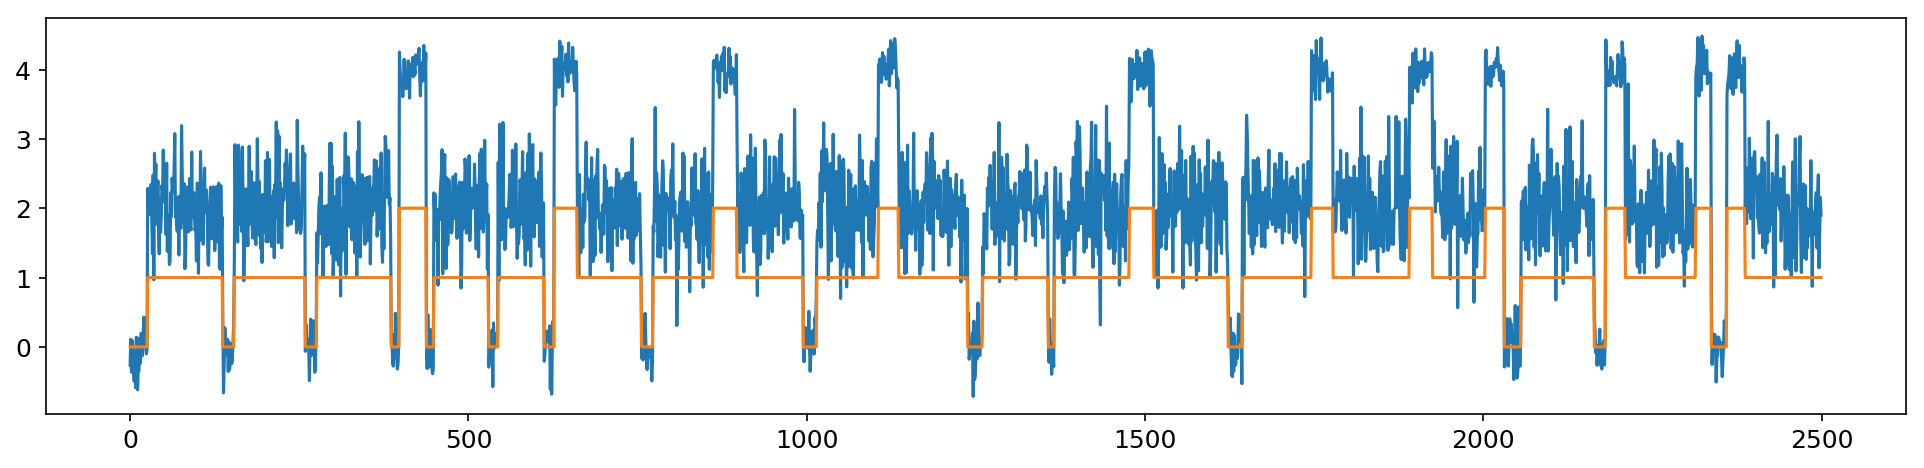

In [817]:
s = SemiMarkovSignal(_means = [0,2,4], _varience=[0.3, 0.5, 0.2], _trans_matrix = [[0.0, 0.7, 0.3],
                                                                                   [0.5, 0.0, 0.5],
                                                                                   [0.2, 0.8, 0.0]],
                 _init_dist=[0, 1.0, 0.0, 0.0],_dur_param = [20,100,30],  _N = 3, T=2500)
plt.figure(dpi = 150, figsize=(16,3.5))
plt.plot(s.sequence)
plt.plot(s.stateseq)

In [644]:
# model = create_model(s.sequence.reshape(-1,1), Nmax=5)

In [818]:
classifiear = hsmm_classifier(N = 2)
classifiear.fit(s.sequence.reshape(-1,1))

Конструктор
Конструктор


/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


.................................................  [  25/150,    1.13sec avg, ETA 02:21 ]
.  [  25/150,    1.13sec avg, ETA 02:22 ]
.................................................  [  50/150,    1.11sec avg, ETA 01:51 ]
.  [  50/150,    1.11sec avg, ETA 01:51 ]
................................................  [  75/150,    1.11sec avg, ETA 01:23 ]
...  [  75/150,    1.12sec avg, ETA 01:24 ]
...............................................  [ 100/150,    1.10sec avg, ETA 54.75 ]
...  [ 100/150,    1.11sec avg, ETA 55.42 ]
...............................................  [ 125/150,    1.10sec avg, ETA 27.40 ]
...  [ 125/150,    1.11sec avg, ETA 27.63 ]
...............................................  [ 150/150,    1.09sec avg, ETA 0.00 ]

   1.09sec avg, 02:44 total

..  [ 150/150,    1.10sec avg, ETA 0.00 ]

   1.10sec avg, 02:45 total



In [819]:
model.dur_distns[0].params['lmbda']

39.4037388092402

In [860]:
for model in classifiear.models:
    print(model.used_states)
    print(model.num_states)
    #     plt.plot(m.durations[0])
    #     m.plot_duration()
    used_states = model.used_states
    used_states.sort()
    for k,dist in enumerate(model.obs_distns):
        if k in used_states:
            print('Состояние: {} | mu = {}, sigma = {}, | lamda = {}'.format(k,dist.params['mu'],
                                                                             np.sqrt(dist.params['sigma'][0]),
                                                                    model.dur_distns[k].params['lmbda']))
        else:
            continue
            print('Состояние: {} , {}'.format(k,dist.params))
    #     print(m.obs_distns[0].params)
    
    print('Матрица переходов')
    print(model.states_list[0].trans_matrix[[used_states]][:,used_states],'\n','')
    for i in used_states:
        for j in used_states:
            print('{:.2F}'.format(model.states_list[0].trans_matrix[i,j]),end=' ',sep=' ')
        print()

[2, 1, 0, 5]
7
Состояние: 0 | mu = [2.01234441], sigma = [0.47869975], | lamda = 46.320978788603554
Состояние: 1 | mu = [2.00119986], sigma = [0.53662877], | lamda = 56.878128491865276
Состояние: 2 | mu = [-0.00738049], sigma = [0.28100697], | lamda = 19.046454137147688
Состояние: 5 | mu = [4.00515571], sigma = [0.37920497], | lamda = 34.32780490805018
Матрица переходов
[[0.00000000e+00 5.32554367e-02 5.61718054e-01 3.85026509e-01]
 [8.26576339e-01 0.00000000e+00 1.36918460e-01 3.65052010e-02]
 [2.70879225e-05 5.11087692e-01 0.00000000e+00 4.88885220e-01]
 [5.36390848e-13 5.33232023e-01 4.66753553e-01 0.00000000e+00]] 
 
0.00 0.05 0.56 0.39 
0.83 0.00 0.14 0.04 
0.00 0.51 0.00 0.49 
0.00 0.53 0.47 0.00 
[3, 2, 6, 5]
7
Состояние: 2 | mu = [2.01061187], sigma = [0.51530227], | lamda = 67.98335483584127
Состояние: 3 | mu = [0.00721211], sigma = [0.25903642], | lamda = 18.904840205226645
Состояние: 5 | mu = [3.96935115], sigma = [0.36805741], | lamda = 32.54199449042839
Состояние: 6 | mu =

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


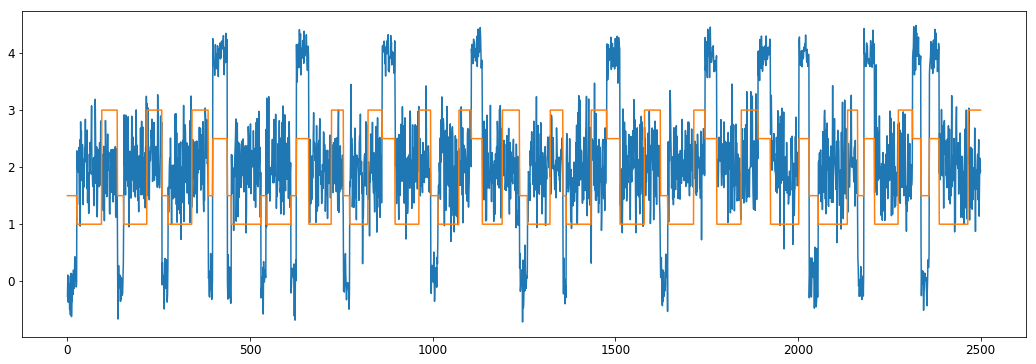

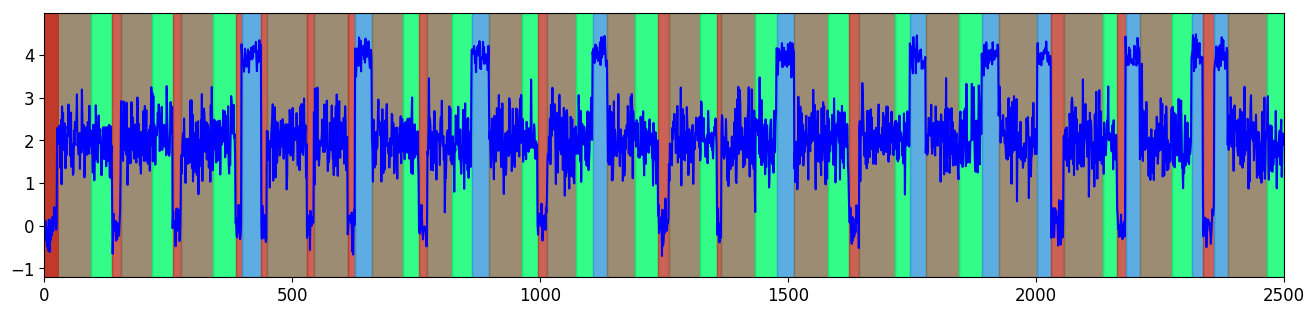

In [873]:
def plot_stateseq(x_, stateseq, draw_stateseq = True):
    plt.figure(figsize=(16,3.5),dpi = 100)
    colors = ['#F1C40F','#2ECC71','#837051','#C0392B','#A569BD','#3498DB','#00FC6B','#C0392B','#837051']
    plt.plot(x_,'blue')
    ymin = np.min(x_) - 0.5
    ymax = np.max(x_) + 0.5
    plt.ylim(ymin, ymax)
    plt.xlim(0,len(stateseq))
    if draw_stateseq == True:
        plt.plot(stateseq+1,'r')
    states, pos = rle(stateseq)
    positions = np.cumsum(pos)
    one = 0
    for state,start,end in zip(states[1:], positions, positions[1:]):
        if one == 0:
            plt.fill_between(x = np.arange(0,positions[0]+1),y1 = ymin, y2 = ymax,color=colors[states[0]], alpha = 0.8)
            one == 1
        plt.fill_between(x = np.arange(start,end+1),y1 = ymin, y2 = ymax,color=colors[state], alpha = 0.8)
    plt.xticks(np.arange(0,len(x_)+1,500))
    return

_, y = model.predict(s.sequence.reshape(-1,1),1)
plt.plot(_)
plt.plot(y/2)

plot_stateseq(_,y,False)

In [874]:
s.stateseq

array([0., 0., 0., ..., 1., 1., 1.])

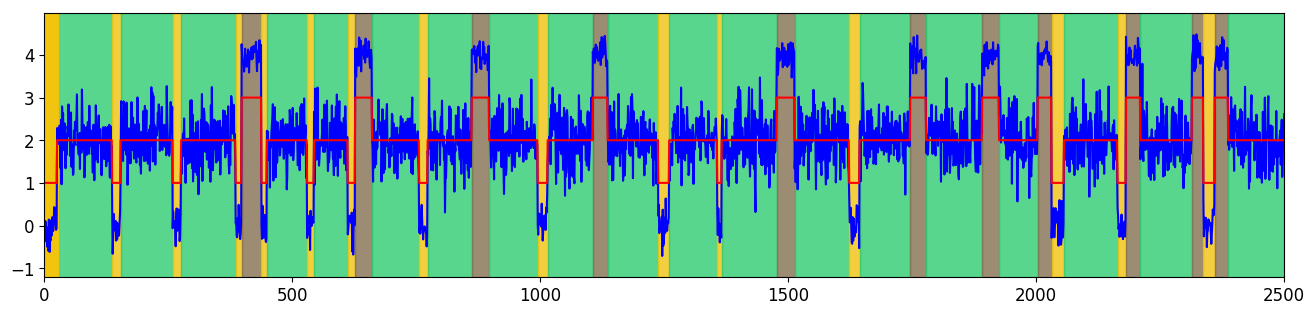

In [872]:
plot_stateseq(_,s.stateseq.astype(np.int32), )

In [864]:
model.states_list[0].pi_0

array([0.29965995, 0.35403054, 0.01973672, 0.22060484, 0.03978841,
       0.03156387, 0.03461567])

In [828]:
for model in classifiear.models:
    print(model.log_likelihood(s.sequence.reshape(-1,1)[:1500]))

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


-993.381584310388
-995.6340558780182


In [824]:
a = np.array([[1,2,3,4,55],
              [5,6,7,8,56]
              [9,10,11,12,57],
              [13,14,15,16,58]])
print(a)
print(a[[0,1],[2,3]])

TypeError: list indices must be integers or slices, not tuple

In [ ]:
used_states.sort()

In [ ]:
model.states_list[0].trans_matrix

In [ ]:
model.states_list[0].trans_matrix[[used_states]]

In [ ]:
model.states_list[0].trans_matrix[[used_states]][:,used_states]

In [ ]:
used_states

In [ ]:
model.states_list[0].trans_matrix.shape

In [ ]:
a[[1,3]][:,[2,4]]